In [1]:
%cd ..

/home/alberto/Work/incomplete_multiview_clustering


/home/alberto/anaconda3/envs/imc/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
from itertools import combinations
from scipy.stats import chi2_contingency
from sklearn.metrics.pairwise import rbf_kernel
from sdmetrics.single_column.statistical import TVComplement
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold

from imml.impute import get_observed_mod_indicator

In [3]:
from tueplots import axes, bundles
plt.rcParams.update(**bundles.icml2022(), **axes.lines())
for key in ["axes.labelsize", "axes.titlesize", "font.size", "legend.fontsize", "xtick.labelsize", "ytick.labelsize"]:
    if key in ["xtick.labelsize", "ytick.labelsize", "legend.fontsize"]:
        plt.rcParams[key] += 3
    else:
        plt.rcParams[key] += 2
plt.rcParams.update({'text.usetex': False, "svg.fonttype": 'none'})

In [4]:
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import Metadata
from sklearn.base import BaseEstimator, TransformerMixin

from imml.impute import get_observed_mod_indicator
from imml.utils import DatasetUtils

class MissingnessPatternTransfer(BaseEstimator, TransformerMixin):

    def __init__(self, random_state: int = None):
        self.random_state = random_state

    
    def fit(self, Xs: list, y=None):
        if not isinstance(Xs[0], pd.DataFrame):
            Xs = [pd.DataFrame(X) for X in Xs]
        observed_mod_indicator = get_observed_mod_indicator(Xs).astype(int)
        estimators = []
        for X in ([observed_mod_indicator] + Xs):
            X = X.fillna(0)
            X = X[~(X == 0).all(1)]
            estimator = GaussianCopulaSynthesizer(Metadata.detect_from_dataframe(data=X))
            estimator.fit(X)
            estimators.append(estimator)

        self.estimators_ = estimators
        return self

    
    def transform(self, Xs: list):
        pandas_format = isinstance(Xs[0], pd.DataFrame)
        transformed_Xs = []
        for i, estimator in enumerate(self.estimators_):
            transformed_X = estimator.sample(len(Xs[0]))
            if i != 0:
                transformed_X.loc[bool_observed_mod_indicator[:,i-1], :] = 0
                transformed_Xs += [transformed_X]
            else:
                observed_mod_indicator = transformed_X.copy()
                bool_observed_mod_indicator = (~(observed_mod_indicator.astype(bool))).values
        
        transformed_Xs = [np.where(transformed_X == 0, np.nan,X) for X, transformed_X in zip(Xs, transformed_Xs)]
        if pandas_format:
            transformed_Xs = [pd.DataFrame(transformed_X, index=X.index, columns=X.columns)
                              for X, transformed_X in zip(Xs, transformed_Xs)]

        return transformed_Xs

In [5]:
def generate_binary_correlated_matrix(n=100, m=15, seed=None, p=.5, max_groups= 10):
    rand = np.random.default_rng(seed)
    base_data = rand.choice([0, 1], size=(n, m), p=[p, 1-p])
    groups = rand.choice(range(1, max_groups))
    for group in range(groups):
        smallest = m//5 if m>=5 else 2
        correlated_group = rand.choice(range(smallest, max(int(m*.75), smallest+1)))
        correlated_group = rand.choice(m, size=correlated_group, replace= False)
        for col in correlated_group:
            base_data[:, col] = np.where(
                base_data[:, correlated_group[0]] == 0,
                rand.choice([1, 0], size=n, p=[0.1, 0.9]),
                rand.choice([1, 0], size=n, p=[0.9, 0.1])
            )

    for row_idx in range(base_data.shape[0]):
        if np.all(base_data[row_idx] == 0):
            random_col = rand.integers(0, m)
            base_data[row_idx, random_col] = 1

    return pd.DataFrame(base_data)

In [6]:
def fisher_test_all_pairs(df1, df2):
    features = df1.columns
    p_values = pd.DataFrame(index=features, columns=features, dtype=float)
    df1 = df1[~(df1 == 0).all(1)]
    df2 = df2[~(df2 == 0).all(1)]

    for col1, col2 in combinations(features, 2):
        contingency1 = pd.crosstab(df1[col1], df1[col2])
        if contingency1.shape != (2, 2):
            contingency1 = contingency1.reindex(index=[0, 1], columns=[0, 1], fill_value=0)
        _, p_value1 = stats.fisher_exact(contingency1)

        contingency2 = pd.crosstab(df2[col1], df2[col2])
        if contingency2.shape != (2, 2):
            contingency2 = contingency2.reindex(index=[0, 1], columns=[0, 1], fill_value=0)
        _, p_value2 = stats.fisher_exact(contingency2)

        p_values.loc[col1, col2] = p_value2
        p_values.loc[col2, col1] = p_value1

    p_values = p_values.values
    ps = p_values.flatten()
    valid_indices = ~np.isnan(ps)
    ps = ps[valid_indices]
    ps = multipletests(ps, method="fdr_bh")[1]
    p_values.flat[valid_indices] = ps
    p_values = pd.DataFrame(p_values)

    return p_values

In [7]:
def mmd_rbf(
    X: pd.DataFrame,
    Y: pd.DataFrame,
    gamma
):
    """
    Maximum Mean Discrepancy (MMD) is a statistical tests
    to determine if two samples are from different distributions.
    This statistic test measures the distance between the means
    of the two samples  mapped into a reproducing kernel Hilbert space (RKHS).
    Maximum Mean Discrepancy has found numerous applications in
    machine learning and nonparametric testing [1][2].

    Maths[3]:
        Compute the radial basis function (RBF) kernel
        between two vectors between X and Y.
        k(x,y) = exp(-gamma * ||x-y||^2 / 2)
        where gamma is the inverse of the standard
        deviation of the RBF. A small gamma value define
        a Gaussian function with a large variance.

    [1] Ilya Tolstikhin, Bharath K. Sriperumbudur, and Bernhard Schölkopf. 2016.
    Minimax estimation of maximum mean discrepancy with radial kernels.
    In Proceedings of the 30th International Conference on Neural
    Information Processing Systems (NIPS'16).
    Curran Associates Inc., Red Hook, NY, USA, 1938–1946.

    [2] A. Gretton, K. M. Borgwardt, M. Rasch, B. Schölkopf, and A. Smola.
    A kernel method for the two sample problem.
    In B. Schölkopf, J. Platt, and T. Hoffman, editors, Advances in Neural
    Information Processing Systems 19, pages 513–520, Cambridge, MA, 2007. MIT Press.

    [3] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

        Args:

           X: ndarray/pd.DataFrame of shape (n_samples_X, n_features)
           Y: ndarray/pd.DataFrame of shape (n_samples_Y, n_features)
           gamma: float

        Returns:
            Maximum Mean Discrepancy (MMD) value
    """

    if gamma is None:
        gamma = 1.0 / X.shape[1]

    XX = rbf_kernel(X, X, gamma)
    YY = rbf_kernel(Y, Y, gamma)
    XY = rbf_kernel(X, Y, gamma)
    mmd = XX.mean() + YY.mean() - 2 * XY.mean()

    return mmd

chi2 = lambda x,y,c: chi2_contingency(pd.crosstab(x[c], y[c])).pvalue
tv = lambda x,y,c: TVComplement().compute(x[c], y[c])
mmd = lambda x,y: mmd_rbf(x, y, gamma=None)
detection = lambda x,y: cross_val_score(
    estimator=LogisticRegression(random_state=42),
    X= pd.concat([x,y]),
    y= [0]*len(x) + [1]*len(y),
    scoring= "f1_macro",
    cv= StratifiedKFold(n_splits=x.shape[1], random_state=42, shuffle=True)
)

In [8]:
n_mods = 3
p = .1
m = 4
n= 100

In [9]:
Xs = [generate_binary_correlated_matrix(n=n, seed=i, p=p, m=m*(i+1), max_groups=3*(i+1)) for i in range(n_mods)]
observed_mod_indicator = generate_binary_correlated_matrix(n=n, seed=0, m=n_mods, p=p, max_groups=3)
for idx,X in enumerate(Xs):
    X.loc[(~observed_mod_indicator.astype(bool)).values[:,idx], :] = 0
    X[X == 0] = np.nan

In [10]:
original_Xs = [pd.DataFrame(np.random.default_rng(i).normal(size= (n, m*(i+1))))  for i in range(n_mods)]
original_Xs = [np.where(X.isna(), np.nan, original_X) for original_X,X in zip(original_Xs, Xs)]
synth_Xs = [pd.DataFrame(np.random.default_rng(i).normal(size= (n*10, m*(i+1))))  for i in range(n_mods)]
synth_observed_mod_indicator = pd.DataFrame(get_observed_mod_indicator(synth_Xs))

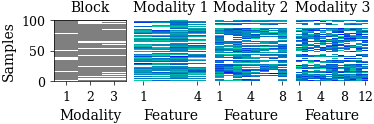

In [11]:
fig,axs = plt.subplots(1,len(original_Xs)+1, figsize= (0.95*(len(original_Xs)+1),1.3))
xlabel,ylabel = "Modality", "Samples"
observed_mods = observed_mod_indicator.copy()
observed_mods.columns = observed_mods.columns + 1
ax = axs[0]
ax.pcolor(observed_mods, cmap="binary", vmin=0., vmax=2.)
ax.set_xticks(np.arange(0.5, len(observed_mods.columns), 1), observed_mods.columns)
ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
ax.set_title("Block")

for idx, (ax, X) in enumerate(zip(axs[1:], original_Xs)):
    cols = [m * i for i in range(1, X.shape[1]//m +1)]
    ax = sns.heatmap(X, cmap="winter", mask=False, cbar=False, ax=ax)
    ax.set_xticks([.5] + cols[:-1] + [cols[-1]-.5], [1] + cols)
    ax.set_title(f"Modality {idx+1}")
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Feature")
    ax.collections[0].cmap.set_bad('white')

plt.savefig("paper_figures/transfer_original.pdf")
plt.savefig("paper_figures/transfer_original.svg")

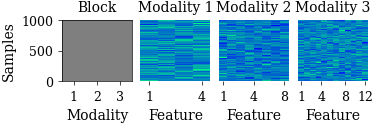

In [12]:
fig,axs = plt.subplots(1,len(original_Xs)+1, figsize= (0.95*(len(original_Xs)+1),1.3))
xlabel,ylabel = "Modality", "Samples"
observed_mods = synth_observed_mod_indicator.copy()
observed_mods.columns = observed_mods.columns + 1
ax = axs[0]
ax.pcolor(observed_mods, cmap="binary", vmin=0., vmax=2.)
ax.set_xticks(np.arange(0.5, len(observed_mods.columns), 1), observed_mods.columns)
ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
ax.set_title("Block")

for idx, (ax, X) in enumerate(zip(axs[1:], synth_Xs)):
    cols = [m * i for i in range(1, X.shape[1]//m +1)]
    ax = sns.heatmap(X, cmap="winter", mask=False, cbar=False, ax=ax)
    ax.set_xticks([.5] + cols[:-1] + [cols[-1]-.5], [1] + cols)
    ax.set_title(f"Modality {idx+1}")
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Feature")
    ax.collections[0].cmap.set_bad('white')

plt.savefig("paper_figures/transfer_observed.pdf")
plt.savefig("paper_figures/transfer_observed.svg")

In [13]:
transformer = MissingnessPatternTransfer(random_state=42)
transformer.fit(Xs)
transformed_Xs = transformer.transform(synth_Xs)
transformed_observed_mod_indicator = pd.DataFrame(get_observed_mod_indicator(transformed_Xs)).astype(int)

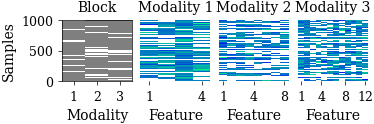

In [14]:
fig,axs = plt.subplots(1,len(original_Xs)+1, figsize= (0.95*(len(original_Xs)+1),1.3), facecolor="white")
xlabel,ylabel = "Modality", "Samples"
observed_mods = transformed_observed_mod_indicator.copy()
observed_mods.columns = observed_mods.columns + 1
ax = axs[0]
ax.pcolor(observed_mods, cmap="binary", vmin=0., vmax=2.)
ax.set_xticks(np.arange(0.5, len(observed_mods.columns), 1), observed_mods.columns)
ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
ax.set_title("Block")

for idx, (ax, X) in enumerate(zip(axs[1:], transformed_Xs)):
    cols = [m * i for i in range(1, X.shape[1]//m +1)]
    ax = sns.heatmap(X, cmap="winter", mask=False, cbar=False, ax=ax)
    ax.set_xticks([.5] + cols[:-1] + [cols[-1]-.5], [1] + cols)
    ax.set_title(f"Modality {idx+1}")
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Feature")

plt.savefig("paper_figures/transfer_transformed.pdf")
plt.savefig("paper_figures/transfer_transformed.svg")

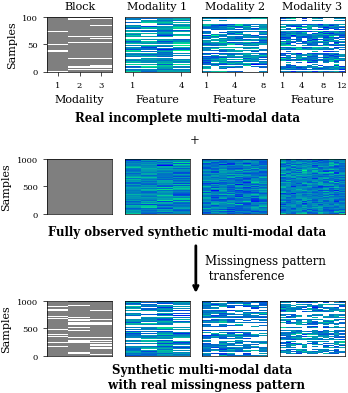

In [48]:
for key in ["axes.labelsize", "axes.titlesize", "font.size", "legend.fontsize", "xtick.labelsize", "ytick.labelsize"]:
    if key in ["xtick.labelsize", "ytick.labelsize", "legend.fontsize"]:
        plt.rcParams[key] -= 3
    else:
        plt.rcParams[key] -= 2

fig,axs = plt.subplots(3,len(original_Xs)+1, figsize= (0.96*(len(original_Xs)+1),4.4), gridspec_kw=dict(hspace=1.6))
xlabel,ylabel = "Modality", "Samples"
observed_mods = observed_mod_indicator.copy()
observed_mods.columns = observed_mods.columns + 1
ax = axs[0, 0]
ax.pcolor(observed_mods, cmap="binary", vmin=0., vmax=2., rasterized=True)
ax.set_xticks(np.arange(0.5, len(observed_mods.columns), 1), observed_mods.columns)
ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
ax.set_title("Block")

for idx, (ax, X) in enumerate(zip(axs[0, 1:], original_Xs)):
    cols = [m * i for i in range(1, X.shape[1]//m +1)]
    ax = sns.heatmap(X, cmap="winter", mask=False, cbar=False, ax=ax, rasterized=True)
    ax.set_xticks([.5] + cols[:-1] + [cols[-1]-.5], [1] + cols)
    ax.set_title(f"Modality {idx+1}")
    ax.get_yaxis().set_visible(False)
    ax.set_xlabel("Feature")
    ax.collections[0].cmap.set_bad('white')
    for _, spine in ax.spines.items(): 
        spine.set_visible(True) 

observed_mods = synth_observed_mod_indicator.copy()
observed_mods.columns = observed_mods.columns + 1
ax = axs[1, 0]
ax.pcolor(observed_mods, cmap="binary", vmin=0., vmax=2., rasterized=True)
ax.set_xticks(np.arange(0.5, len(observed_mods.columns), 1), observed_mods.columns)
ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
ax.get_xaxis().set_visible(False)
# ax.set_title("Block")

for idx, (ax, X) in enumerate(zip(axs[1, 1:], synth_Xs)):
    cols = [m * i for i in range(1, X.shape[1]//m +1)]
    ax = sns.heatmap(X, cmap="winter", mask=False, cbar=False, ax=ax, rasterized=True)
    # ax.set_xticks([.5] + cols[:-1] + [cols[-1]-.5], [1] + cols)
    # ax.set_title(f"Modality {idx+1}")
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    # ax.set_xlabel("Feature")
    ax.collections[0].cmap.set_bad('white')
    for _, spine in ax.spines.items(): 
        spine.set_visible(True) 

observed_mods = transformed_observed_mod_indicator.copy()
observed_mods.columns = observed_mods.columns + 1
ax = axs[2, 0]
ax.pcolor(observed_mods, cmap="binary", vmin=0., vmax=2., rasterized=True)
ax.set_xticks(np.arange(0.5, len(observed_mods.columns), 1), observed_mods.columns)
ax.set_xlabel(xlabel), ax.set_ylabel(ylabel)
ax.get_xaxis().set_visible(False)

for idx, (ax, X) in enumerate(zip(axs[2, 1:], transformed_Xs)):
    cols = [m * i for i in range(1, X.shape[1]//m +1)]
    ax = sns.heatmap(X, cmap="winter", mask=False, cbar=False, ax=ax, rasterized=True)
    ax.set_xticks([.5] + cols[:-1] + [cols[-1]-.5], [1] + cols)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.collections[0].cmap.set_bad('white')
    for _, spine in ax.spines.items(): 
        spine.set_visible(True) 

plt.text(-38, -3300, "Real incomplete multi-modal data", fontsize=8.5, weight="bold")
plt.text(-16.85, -2900, "+", fontsize=8.5)
plt.text(-43, -1200, "Fully observed synthetic multi-modal data", fontsize=8.5, weight="bold")
plt.annotate('', xy=(141, 70), xytext=(141, 108), xycoords= "figure points", arrowprops=dict(arrowstyle="->", lw=2))
plt.text(-14, -400, "Missingness pattern \n transference", fontsize=8.5, horizontalalignment='left')
plt.text(-14, 1600, "Synthetic multi-modal data \n with real missingness pattern", fontsize=8.5, weight="bold", horizontalalignment='center')

plt.savefig("paper_figures/transfer_pattern.pdf")
plt.savefig("paper_figures/transfer_pattern.svg")

for key in ["axes.labelsize", "axes.titlesize", "font.size", "legend.fontsize", "xtick.labelsize", "ytick.labelsize"]:
    if key in ["xtick.labelsize", "ytick.labelsize", "legend.fontsize"]:
        plt.rcParams[key] += 3
    else:
        plt.rcParams[key] += 2

In [48]:
Xs = [X.fillna(0).astype(int) for X in Xs]
transformed_Xs = [transformed_X.notnull().astype(int) for transformed_X in transformed_Xs]

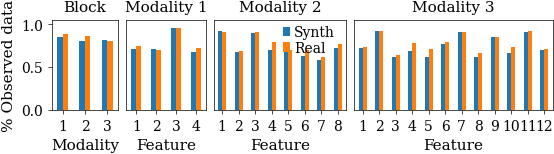

In [49]:
fig,axs = plt.subplots(1,len(transformed_Xs)+1, figsize= (1.4*(len(transformed_Xs)+1),1.6), gridspec_kw={'width_ratios': [1, 1.2, 2, 3]})
diff = pd.concat([transformed_observed_mod_indicator.mean(), observed_mod_indicator.mean()], axis=1)
diff.columns = ["Synth", "Real"]
diff.index = diff.index + 1
ax = axs[0]
diff.plot(kind="bar", title="Block", rot=0, ylabel="% Observed data",
          ylim=(-0.0,1.05), ax=ax, xlabel="Modality", legend=None)

for idx, (ax, transformed_X,X) in enumerate(zip(axs[1:],transformed_Xs,Xs)):
    transformed_X = transformed_X[~(transformed_X == 0).all(1)]
    X = X[~(X == 0).all(1)]
    diff = pd.concat([transformed_X.mean(), X.mean()], axis=1)
    diff.columns = ["Synth", "Real"]
    diff.index = diff.index + 1
    if idx == (len(Xs)-2):
        ax = diff.plot(kind="bar", ax=ax, rot=0,
                           legend=True,
                           ylim=(-0.0,1.05), xlabel="Feature")
        ax.legend(loc="upper right", bbox_to_anchor=(1.01, 1.08), handlelength=.5, frameon=False, labelspacing=.1, handletextpad=.3)
    else:
        ax = diff.plot(kind="bar", ax=ax, rot=0,
                       legend=None,
                       ylim=(-0.0,1.05), xlabel="Feature")
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Modality {idx+1}")

plt.savefig("paper_figures/transfer_percentage.pdf")
plt.savefig("paper_figures/transfer_percentage.svg")

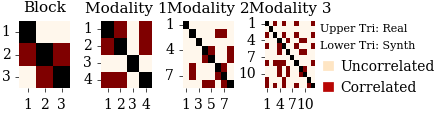

In [50]:
colorblind_palette = sns.color_palette("OrRd")
colorblind_palette = [colorblind_palette[0], colorblind_palette[-1]]
fig,axs = plt.subplots(1,len(transformed_Xs)+1, figsize= (1.15*(len(transformed_Xs)+2),1.2))
corr = fisher_test_all_pairs(transformed_observed_mod_indicator, observed_mod_indicator) < 0.05
corr = corr.values.astype(float)
np.fill_diagonal(corr, np.nan)
corr = pd.DataFrame(corr, index= range(1, len(corr) + 1), columns= range(1, len(corr) + 1))
ax = axs[0]
ax = sns.heatmap(corr, cmap="OrRd", ax=ax, cbar=False)
ax.collections[0].cmap.set_bad('black')
ax.set_title("Block")
ax.tick_params(axis='y', rotation=0)

for idx, (ax, transformed_X,X) in enumerate(zip(axs[1:],transformed_Xs,Xs)):
    corr = fisher_test_all_pairs(transformed_X, X) < 0.05
    corr = corr.values.astype(float)
    np.fill_diagonal(corr, np.nan)
    corr = pd.DataFrame(corr, index= range(1, len(corr) + 1), columns= range(1, len(corr) + 1))
    if idx == (len(Xs)-1):
        ax = sns.heatmap(corr, cmap="OrRd", ax=ax, cbar=False, yticklabels=3, xticklabels=3)
        handles = [plt.Line2D([0], [0], color=c, lw=7) for c in colorblind_palette]
        ax.legend(handles=handles, handlelength=.05,
                  labels=["Uncorrelated", "Correlated"])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, .6), frameon=False, handlelength=.1)

    else:
        ax = sns.heatmap(corr, cmap="OrRd", ax=ax, cbar=False)
    ax.tick_params(axis='y', rotation=0)
    ax.collections[0].cmap.set_bad('black')
    ax.set_title(f"Modality {idx+1}")

ax.text(13.2, 2., "Upper Tri: Real", fontsize=8)
ax.text(13.2, 5, "Lower Tri: Synth", fontsize=8)
plt.tight_layout()

plt.savefig("paper_figures/transfer_corr.pdf")
plt.savefig("paper_figures/transfer_corr.svg")

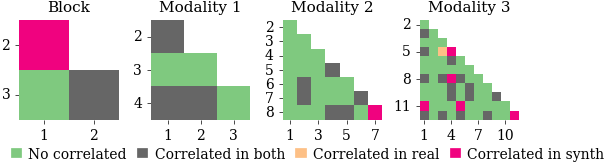

In [51]:
palette = "Accent"
colorblind_palette = sns.color_palette(palette)
colorblind_palette = [colorblind_palette[0], colorblind_palette[-1], colorblind_palette[2], colorblind_palette[-3]]
fig,axs = plt.subplots(1,len(transformed_Xs)+1, figsize= (1.33*(len(transformed_Xs)+1),1.5))
corr = fisher_test_all_pairs(transformed_observed_mod_indicator, observed_mod_indicator) < 0.05
diff = corr.copy()
diff[(corr == False).values & (corr.T == False).values] = 0
diff[(corr == False).values & (corr.T == True).values] = 1
diff[(corr == True).values & (corr.T == False).values] = 2
diff[(corr == True).values & (corr.T == True).values] = 3
diff = diff.values
diff[np.triu_indices_from(diff)] = np.nan
diff = pd.DataFrame(diff, index= range(1, len(diff) + 1), columns= range(1, len(diff) + 1))
diff = diff.astype(float)
ax = axs[0]
ax = sns.heatmap(diff.iloc[1:, :-1], cmap=palette, vmin=0, vmax=3, ax=ax,
                 cbar=False, square=True)
ax.set_title("Block")
ax.tick_params(axis='y', rotation=0)

for idx, (ax, transformed_X,X) in enumerate(zip(axs[1:],transformed_Xs,Xs)):
    corr = fisher_test_all_pairs(transformed_X, X) < 0.05
    diff = corr.copy()
    diff[(corr == False).values & (corr.T == False).values] = 0
    diff[(corr == False).values & (corr.T == True).values] = 1
    diff[(corr == True).values & (corr.T == False).values] = 2
    diff[(corr == True).values & (corr.T == True).values] = 3
    diff = diff.values
    diff[np.triu_indices_from(diff)] = np.nan
    diff = pd.DataFrame(diff, index= range(1, len(diff) + 1), columns= range(1, len(diff) + 1))
    diff = diff.astype(float)
    if idx == (len(Xs)-1):
        ax = sns.heatmap(diff.iloc[1:, :-1], cmap=palette, vmin=0, vmax=3, ax=ax,
                         cbar=False, square=True, yticklabels=3, xticklabels=3)
        handles = [plt.Line2D([0], [0], color=c, lw=7) for c in colorblind_palette]
        ax.legend(handles=handles, handlelength=.05,
                  labels=["No correlated", "Correlated in both", "Correlated in real", "Correlated in synth"])
        sns.move_legend(ax, "upper left", bbox_to_anchor=(-4.19, -0.15), ncol=4,
                        frameon=False, handlelength=.1, columnspacing=1.1)
    else:
        ax = sns.heatmap(diff.iloc[1:, :-1], cmap=palette, vmin=0, vmax=3, ax=ax,
                         cbar=False, square=True)
    ax.set_title(f"Modality {idx+1}")
    ax.tick_params(axis='y', rotation=0)
plt.tight_layout()

plt.savefig("paper_figures/transfer_corr_diff.pdf")
plt.savefig("paper_figures/transfer_corr_diff.svg")

In [20]:
metrics = []
for modality, (X, transformed_X) in enumerate(zip(([observed_mod_indicator] + Xs), ([transformed_observed_mod_indicator] + transformed_Xs))):
    modality_name = "Block" if modality == 0 else modality

    metric_dict = {}
    metric_dict["MMD"] = mmd(X,transformed_X)
    metric_dict["F1"] = detection(X,transformed_X)
    for metric, name_metric in zip([tv, chi2], ["TV", "Chi2"]):
        if name_metric == "Chi2":
            metric_dict[name_metric] = multipletests([chi2(X,transformed_X,col) for col in range(transformed_X.shape[1])], method="fdr_bh")[1].tolist()
        else:
            metric_dict[name_metric] = [metric(X,transformed_X,col) for col in range(transformed_X.shape[1])]

    # Append results for boxplots
    metrics.extend(
        [{"Modality": modality_name, **metric_dict}]
    )
# Convert to DataFrame
metrics_df = pd.DataFrame(metrics)
metrics_df = metrics_df.explode(['TV', "Chi2", "F1"], ignore_index=True)
metrics_df.loc[metrics_df.duplicated("MMD"), ["MMD"]] = np.nan

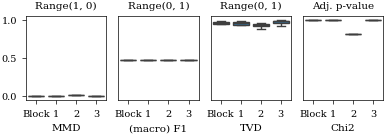

In [21]:
for key in ["axes.labelsize", "axes.titlesize", "ytick.labelsize", "xtick.labelsize"]:
    if key in ["axes.labelsize", "axes.titlesize"]:
        plt.rcParams[key] -= 2.5
    else:
        plt.rcParams[key] -= 2

fig,axs = plt.subplots(1,len(metrics), figsize= (.975*len(metrics),1.4))
metrics = metrics_df.drop(columns="Modality").columns
for idx, (ax, metric) in enumerate(zip(axs,metrics)):
    current_metrics_df = metrics_df[["Modality", metric]]
    ax = sns.boxplot(data=metrics_df, x="Modality", y=metric, ax=ax)
    ax.set_ylim((-0.05,1.05))
    if idx != 0:
        ax.get_yaxis().set_visible(False)
    ax.set_ylabel(None)
    if metric == "MMD":
        ax.set_xlabel("MMD")
        ax.set_title("Range(1, 0)")
    elif metric == "F1":
        ax.set_xlabel("(macro) F1")
        ax.set_title("Range(0, 1)")
    elif metric == "TV":
        ax.set_xlabel("TVD")
        ax.set_title("Range(0, 1)")
    elif metric == "Chi2":
        ax.set_xlabel("Chi2")
        ax.set_title("Adj. p-value")

plt.savefig("paper_figures/transfer_metrics.pdf")
plt.savefig("paper_figures/transfer_metrics.svg")